In [71]:
import pandas as pd
from functools import reduce
import sqlite3
from sqlite3 import Error
import csv

In [72]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
material_path = "/content/drive/MyDrive/Material"

In [74]:
# list of diseases
!ls "/content/drive/MyDrive/Material"

csv_data  DWH_dbs	      import_csv_into_sql.ipynb  TemplateDatenmanagementplan.docx
dest_dbs  ETLprototype.ipynb  source_dbs


In [75]:
## type of patients
# patient_type = "allergy"
# patient_type = "asthma"
# patient_type = "breast_cancer"
# patient_type = "metabolic_syndrome_disease"
# patient_type = "colorectal_cancer"
patient_type = "covid19"
# patient_type = "dermatitis"
# patient_type = "lung_cancer"


In [76]:
# source database path
DB_FILE_PATH = f"{material_path}/source_dbs/source_{patient_type}_test.db"

# folder contains csv files
csv_path = f"{material_path}/csv_data/{patient_type}/"

DB_FILE_PATH, csv_path

('/content/drive/MyDrive/Material/source_dbs/source_covid19_test.db',
 '/content/drive/MyDrive/Material/csv_data/covid19/')

In [77]:
import os
# check if database already exists and delete
if os.path.exists(DB_FILE_PATH):
  os.remove(DB_FILE_PATH)
  print("database deleted")

database deleted


# SQL queries to create tables
There are more info about tables in https://github.com/synthetichealth/synthea/wiki/CSV-File-Data-Dictionary




In [78]:
# dictionary key: name of table, values: sql query to create table
sql_table = {}

In [79]:
#  sql query to create patients table
sql_table["patients"] = """CREATE TABLE IF NOT EXISTS patients (
                           Id STRING PRIMARY KEY,
                           BIRTHDATE DATE,
                           DEATHDATE DATE,
                           SSN STRING,
                           DRIVERS STRING,
                           PASSPORT STRING,
                           PREFIX STRING,
                           FIRST STRING,
                           LAST STRING,
                           SUFFIX STRING,
                           MAIDEN STRING,
                           MARITAL STRING,
                           RACE STRING,
                           ETHNICITY STRING,
                           GENDER STRING,
                           BIRTHPLACE STRING,
                           ADDRESS STRING,
                           CITY STRING,
                           STATE STRING,
                           COUNTRY STRING,
                           ZIP STRING,
                           LAT INTEGER,
                           LON INTEGER,
                           HEALTHCARE_EXPENSES INTEGER,
                           HEALTHCARE_COVERAGE INTEGER
                       );"""


In [80]:
#  sql query to create encounters table
sql_table["encounters"] = """CREATE TABLE IF NOT EXISTS encounters (
                           Id STRING PRIMARY KEY,
                           START DATE,
                           STOP DATE,
                           PATIENT STRING,
                           ORGANIZATIONS STRING,
                           PROVIDER STRING,
                           PAYER STRING,
                           ENCOUNTERCLASS STRING,
                           CODE STRING,
                           DESCRIPTION STRING,
                           BASE_ENCOUNTER_COST INTEGER,
                           TOTAL_CLAIM_COST INTEGER,
                           PAYER_COVERAGE INTEGER,
                           REASONCODE STRING,
                           REASONDESCRIPTION STRING,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id)
                       );"""



In [81]:
# sql query to create conditions table
sql_table["conditions"] = """CREATE TABLE IF NOT EXISTS conditions(
                           START DATE,
                           STOP DATE,
                           PATIENT STRING,
                           ENCOUNTER STRING,
                           CODE STRING,
                           DESCRIPTION STRING,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id)
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id)
                       );"""


In [82]:
# sql query to create Observations table
sql_table["observations"]= """CREATE TABLE IF NOT EXISTS observations(
                           DATE DATE,
                           PATIENT STRING,
                           ENCOUNTER STRING,
                           CODE STRING,
                           DESCRIPTION STRING,
                           VALUE STRING,
                           UNITS STRING,
                           TYPE STRING,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id)
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id)
                       );"""

In [83]:
def connect_to_db(db_file):
    """
    Connect to an SQlite database, if db file does not exist it will be created
    :param db_file: absolute or relative path of db file
    :return: sqlite3 connection
    """
    sqlite3_conn = None

    try:
        sqlite3_conn = sqlite3.connect(db_file)
        return sqlite3_conn

    except Error as err:
        print(err)

        if sqlite3_conn is not None:
            sqlite3_conn.close()


def insert_values_to_table(cursor, table_name, csv_file_path):

    """
    Open a csv file, store its content in a list excluding header and insert the data from the list to db table
    :param table_name: table name in the database to insert the data into
    :param csv_file_path: path of the csv file to process
    :return: None
    """

    # Read CSV file content
    values_to_insert = open_csv_file(csv_file_path)

    # Insert to table
    if len(values_to_insert) > 0:
        column_names, column_numbers = get_column_names_from_db_table(cursor, table_name)

        values_str = '?,' * column_numbers
        # print("*****", values_str, column_names, column_numbers)
        values_str = values_str[:-1]

        sql_query = 'INSERT OR REPLACE INTO ' + table_name + '(' + column_names + ') VALUES (' + values_str + ')'


        cursor.executemany(sql_query, values_to_insert)
        # conn.commit()

        print('SQL insert process finished')
    else:
        print('Nothing to insert')

        # conn.close()

    # else:
        # print('Connection to database failed')


def open_csv_file(csv_file_path):
    """
    Open and read data from a csv file without headers (skipping the first row)
    :param csv_file_path: path of the csv file to process
    :return: a list with the csv content
    """
    with open(csv_file_path, 'r', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)

        data = list()
        for row in reader:
            data.append(row)

        return data


def get_column_names_from_db_table(sql_cursor, table_name):
    """
    Scrape the column names from a database table to a list and convert to a comma separated string, count the number
    of columns in a database table
    :param sql_cursor: sqlite cursor
    :param table_name: table name to get the column names from
    :return: a comma separated string with column names, an integer with number of columns
    """

    table_column_names = 'PRAGMA table_info(' + table_name + ');'
    sql_cursor.execute(table_column_names)
    table_column_names = sql_cursor.fetchall()

    column_count = len(table_column_names)

    column_names = list()

    for name in table_column_names:
        column_names.append(name[1])

    return ', '.join(column_names), column_count




In [84]:
# list of tables
sql_table.keys()

dict_keys(['patients', 'encounters', 'conditions', 'observations'])

In [85]:
# # remove all tables in a db
# for name in sql_table.keys():
#   cursor.execute(f"drop table if exists {name}")


In [86]:
# import csv into db
conn = connect_to_db(DB_FILE_PATH)
if conn is not None:
        cursor = conn.cursor()
        # enable foreign key constraints
        cursor.execute("PRAGMA foreign_keys = OFF")
        conn.commit()
        for name in sql_table.keys():
          csv_file = csv_path + name + ".csv"
          print(name, csv_file)

          cursor.execute(sql_table[name])

          insert_values_to_table(cursor, name, csv_file)
          conn.commit()
else:
        print('Connection to database failed')


patients /content/drive/MyDrive/Material/csv_data/covid19/patients.csv
SQL insert process finished
encounters /content/drive/MyDrive/Material/csv_data/covid19/encounters.csv
SQL insert process finished
conditions /content/drive/MyDrive/Material/csv_data/covid19/conditions.csv
SQL insert process finished
observations /content/drive/MyDrive/Material/csv_data/covid19/observations.csv
SQL insert process finished


In [87]:
# List of tables in database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('patients',), ('encounters',), ('conditions',), ('observations',)]


In [88]:
# check data in a table
cursor.execute("SELECT * FROM observations limit 5;")
rows = cursor.fetchall()
for row in rows:
  print(row)

('2020-02-17T21:57:21Z', 'ad5525c0-fdab-94dc-018f-d7209c72bdef', '1d453a83-17f7-490d-5576-09f5725cdcaa', '8310-5', 'Body temperature', 41.4, 'Cel', 'numeric')
('2020-02-17T21:57:21Z', 'ad5525c0-fdab-94dc-018f-d7209c72bdef', '1d453a83-17f7-490d-5576-09f5725cdcaa', '9279-1', 'Respiratory rate', 21.4, '/min', 'numeric')
('2020-02-17T21:57:21Z', 'ad5525c0-fdab-94dc-018f-d7209c72bdef', '1d453a83-17f7-490d-5576-09f5725cdcaa', '8867-4', 'Heart rate', 61.6, '/min', 'numeric')
('2020-02-17T21:57:21Z', 'ad5525c0-fdab-94dc-018f-d7209c72bdef', '1d453a83-17f7-490d-5576-09f5725cdcaa', '2708-6', 'Oxygen saturation in Arterial blood', 77.4, '%', 'numeric')
('2020-02-17T21:57:21Z', 'ad5525c0-fdab-94dc-018f-d7209c72bdef', '1d453a83-17f7-490d-5576-09f5725cdcaa', '8462-4', 'Diastolic Blood Pressure', 85, 'mm[Hg]', 'numeric')


In [89]:
# check data in a table
cursor.execute("SELECT * FROM encounters limit 5;")
rows = cursor.fetchall()
for row in rows:
  print(row)

('7627d701-6c75-be69-0fcc-aeb32ea27270', '2013-10-21T09:22:47Z', '2013-10-21T09:37:47Z', 'f7dddcba-380e-7fd4-20b0-da086ce5dc3a', '3feeb8f0-7e8a-3cbb-8557-3cd7df027ce1', '7f540f46-bac2-342c-bc19-49f3689f92fa', '42c4fca7-f8a9-3cd1-982a-dd9751bf3e2a', 'wellness', 162673000, 'General examination of patient (procedure)', 129.16, 129.16, 129.16, '', '')
('e0361112-89b9-9057-f577-ce5878f47f86', '2011-09-17T21:57:21Z', '2011-09-17T22:12:21Z', 'ad5525c0-fdab-94dc-018f-d7209c72bdef', '1248b93c-56ef-3c3a-adab-56eb2c991c4d', '815da5a3-1099-3657-ab9e-68d4e6c601cc', '7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a', 'wellness', 162673000, 'General examination of patient (procedure)', 129.16, 129.16, 129.16, '', '')
('2891a0e4-ee92-6a31-c4e4-5de8cedddf19', '2011-09-11T17:40:13Z', '2011-09-11T17:55:13Z', '2812f4fc-6aba-0033-728b-7e569bb8adcc', '5b1e6842-ca09-3521-ae67-3dbf4ff7638f', '03912e14-e103-393a-9c30-9c7dc13938f9', '7caa7254-5050-3b5e-9eae-bd5ea30e809c', 'wellness', 162673000, 'General examination of pati

In [90]:
# check data in a table
cursor.execute("SELECT * FROM patients limit 5;")
rows = cursor.fetchall()
for row in rows:
  print(row)

('2f114e21-8b95-e9eb-2e9e-4b950b059cfa', '2002-05-05', '', '999-23-8106', 'S99926648', '', 'Ms.', 'Terisa250', 'Kreiger457', '', '', '', 'white', 'nonhispanic', 'F', 'Oxford  Massachusetts  US', '325 Robel Route Apt 85', 'Swampscott', 'Massachusetts', 'Essex County', 1907, 42.4727363030401, -70.87652826750256, 471180, 2784.81)
('2812f4fc-6aba-0033-728b-7e569bb8adcc', '1942-05-24', '', '999-24-5281', 'S99910925', 'X76697172X', 'Mr.', 'Romeo514', 'Morar593', '', '', 'M', 'white', 'nonhispanic', 'M', 'Springfield  Massachusetts  US', '496 Klein Wynd Unit 85', 'Charlton', 'Massachusetts', 'Worcester County', '', 42.13146482202136, -71.97033335268013, 1606235, 5375.37)
('9b1a203a-6368-49a5-0c79-45c32729bc17', '2013-06-15', '', '999-75-9525', '', '', '', 'Jamaal34', 'Hessel84', '', '', '', 'white', 'nonhispanic', 'M', 'Framingham  Massachusetts  US', '184 Corkery Byway', 'Methuen', 'Massachusetts', 'Essex County', '', 42.730659566644164, -71.15944177306567, 172970, 2074.0499999999997)
('52a2

In [91]:
query_patients = """
  SELECT prefix, first, last FROM patients limit 5;
"""

# Ausführen der Abfrage und Speichern der Ergebnisse in einem DataFrame
df_patients = pd.read_sql_query(query_patients, conn)
display(df_patients)

,PREFIX,FIRST,LAST
0,Ms.,Terisa250,Kreiger457
1,Mr.,Romeo514,Morar593
2,,Jamaal34,Hessel84
3,Ms.,Kenya524,Leuschke194
4,Mr.,Clark193,Little434


In [92]:
#create a query statement to identify how many patients have a corresponding condition code 840539006 counting every patient just once
query_conditions = """
 SELECT COUNT(DISTINCT patient) FROM conditions WHERE conditions.code = '840539006';
"""

# Ausführen der Abfrage und Speichern der Ergebnisse in einem DataFrame
df_conditions = pd.read_sql_query(query_conditions, conn)
display(df_conditions)

,COUNT(DISTINCT patient)
0,865


In [93]:
#create a query statement to identify how many patients have a corresponding description value Not Detected counting every patient just once
query_observations = """
  SELECT COUNT(DISTINCT patient)
FROM observations
WHERE observations.VALUE LIKE 'Detected%';
"""

# Ausführen der Abfrage und Speichern der Ergebnisse in einem DataFrame
df_observations = pd.read_sql_query(query_observations, conn)
display(df_observations)

,COUNT(DISTINCT patient)
0,867


In [94]:
#create a query statement to identify how many patients have adescription value Not Detected  (counting every patient just once) corresponding to a conditon code : 840539006
query_observations = """SELECT count(DISTINCT patients.Id), observations.VALUE, conditions.CODE
FROM patients
JOIN observations ON patients.Id = observations.PATIENT
JOIN conditions ON patients.Id = conditions.PATIENT
WHERE observations.CODE = '94531-1'
  AND observations.VALUE LIKE 'Not detected%'
  AND conditions.CODE = '840539006';
"""
#Ausführen der Abfrage und Speichern der Ergebnisse in einem DataFrame
df_observations = pd.read_sql_query(query_observations, conn)
display(df_observations)


,count(DISTINCT patients.Id),VALUE,CODE
0,105,Not detected (qualifier value),840539006


In [95]:
query_patients_with_observations_conditions = """
SELECT *
FROM patients
JOIN observations ON patients.Id = observations.PATIENT
JOIN conditions ON patients.Id = conditions.PATIENT
WHERE ID='ad5525c0-fdab-94dc-018f-d7209c72bdef';
"""
df_patients_with_observations_conditions = pd.read_sql_query(query_patients_with_observations_conditions, conn)
df_patients_with_observations_conditions


,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,DESCRIPTION,VALUE,UNITS,TYPE,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28,,999-29-9941,S99959414,X19338033X,Mr.,Clark193,Little434,,...,Body temperature,41.4,Cel,numeric,2020-02-17,2020-02-17,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,840544004,Suspected COVID-19
1,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28,,999-29-9941,S99959414,X19338033X,Mr.,Clark193,Little434,,...,Body temperature,41.4,Cel,numeric,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,36955009,Loss of taste (finding)
2,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28,,999-29-9941,S99959414,X19338033X,Mr.,Clark193,Little434,,...,Body temperature,41.4,Cel,numeric,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,49727002,Cough (finding)
3,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28,,999-29-9941,S99959414,X19338033X,Mr.,Clark193,Little434,,...,Body temperature,41.4,Cel,numeric,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,386661006,Fever (finding)
4,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28,,999-29-9941,S99959414,X19338033X,Mr.,Clark193,Little434,,...,Body temperature,41.4,Cel,numeric,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,840539006,COVID-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4011,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28,,999-29-9941,S99959414,X19338033X,Mr.,Clark193,Little434,,...,QOLS,1,{score},numeric,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,386661006,Fever (finding)
4012,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28,,999-29-9941,S99959414,X19338033X,Mr.,Clark193,Little434,,...,QOLS,1,{score},numeric,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,840539006,COVID-19
4013,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28,,999-29-9941,S99959414,X19338033X,Mr.,Clark193,Little434,,...,QOLS,1,{score},numeric,2020-02-18,,ad5525c0-fdab-94dc-018f-d7209c72bdef,f20cdb9e-6457-a462-80b9-b1fccfc22526,389087006,Hypoxemia (disorder)
4014,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28,,999-29-9941,S99959414,X19338033X,Mr.,Clark193,Little434,,...,QOLS,1,{score},numeric,2020-02-18,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,f20cdb9e-6457-a462-80b9-b1fccfc22526,233604007,Pneumonia (disorder)


In [96]:
unspecific_symptom_codes = [
    "22298006", "25064002", "40095003", "43724002", "49436004",
    "49727002", "53741008", "56018004", "57676002", "65710008", "66857006",
    "67782005", "68235000", "68962001", "76571007", "84114007", "84229001",
    "86175003", "87628006", "230690007", "233604007", "234466008", "246677007",
    "248595008", "249497008", "267036007", "267060006", "267102003",
    "386661006", "389087006", "399211009", "410429000", "422587007", "429007001",
    "706870000", "770349000", "132281000119108"
]
specific_symptom_codes = ["271825005", "36955009"]
snomed = ["840539006","840544004"]
snomed_suspected = "840544004"
snomed_covid = "840539006"
death_certificate_code = "308646001"
loinc_covid_test = "94531-1"

covid_positive_patient_id = "52a250a9-24e4-ec9b-91d6-c38cf1b10fc0"
patient_with_specific_symptom_id = "b7f0aa3e-0678-7d03-ee5a-74da32590ac4"
patient_with_death_certificate_id = "6b1cbf81-a420-f97b-e490-c9498b89a078"
patient_with_death_certificate_and_covid_id = "20604c29-ee90-6073-13f4-df3678392fc7"


In [97]:
def has_positive_covid_test(patient_id):
  cursor.execute("SELECT * FROM observations WHERE observations.PATIENT = ? AND observations.CODE = ? AND observations.VALUE LIKE 'Detected%'", (patient_id, loinc_covid_test))
  rows = cursor.fetchall()
  #print(rows)
  return len(rows) > 0

def has_specific_symptom(patient_id):
  cursor.execute("SELECT * FROM conditions WHERE conditions.PATIENT = ? AND conditions.CODE IN ('271825005','36955009')", (patient_id,))
  rows = cursor.fetchall()
  #print(rows)
  return len(rows) > 0

def has_unspecific_symptom(patient_id):
  cursor.execute("""SELECT * FROM conditions WHERE conditions.PATIENT = ? AND conditions.CODE IN ('22298006','25064002','36955009','40095003','43724002','49436004',
'49727002','53741008','56018004','57676002','65710008','66857006',
'67782005','68235000','68962001','76571007','84114007','84229001',
'86175003','87628006','230690007','233604007','234466008','246677007',
'248595008','249497008','267036007','267060006','267102003','271825005',
'386661006','389087006','399211009','410429000','422587007','429007001',
'706870000','770349000','840539006','840544004','132281000119108')""", (patient_id, ))
  rows = cursor.fetchall()
  #print(rows)
  return len(rows) > 0

def has_death_certificate(patient_id):
  cursor.execute(f"SELECT * FROM encounters where encounters.patient = '{patient_id}' AND encounters.code = '{death_certificate_code}'")
  rows = cursor.fetchall()
  return len(rows) > 0

def has_snomed_suspected(patient_id):
  cursor.execute(f"SELECT * FROM conditions where conditions.patient = '{patient_id}' AND conditions.code = '{snomed_suspected}'")
  rows = cursor.fetchall()
  #print(rows)
  return len(rows) > 0

def has_snomed_covid(patient_id):
  cursor.execute(f"SELECT * FROM conditions where conditions.patient = '{patient_id}' AND conditions.code = '{snomed_covid}'")
  rows = cursor.fetchall()
  #print(rows)
  return len(rows) > 0

def get_patient(patient_id):
  return cursor.execute("SELECT * FROM patients WHERE patients.Id = ?", (covid_positive_patient_id,)).fetchone()



In [98]:
"','".join(specific_symptom_codes)

"271825005','36955009"

In [99]:
#all_patients = pd.read_sql_query("SELECT * FROM patients", conn)
positive_patient = get_patient(covid_positive_patient_id)
patient_with_specific_symptom = get_patient(patient_with_specific_symptom_id)
#print(f"All patients: {len(all_patients)}")

patient_id = patient_with_specific_symptom_id
print(f"Has positive covid test: {has_positive_covid_test(patient_id)}")
print(f"Has specific symptom: {has_specific_symptom(patient_id)}")
print(f"Has unspecific symptom: {has_unspecific_symptom(patient_id)}")
print(f"Has death certificate: {has_death_certificate(patient_with_death_certificate_id)}")
print(f"Has snomed suspected: {has_snomed_suspected(patient_id)}")
print(f"Has snomed covid: {has_snomed_covid(patient_id)}")



Has positive covid test: True
Has specific symptom: True
Has unspecific symptom: True
Has death certificate: True
Has snomed suspected: True
Has snomed covid: True


In [100]:
def get_patient_icd_10_code(patient_id) -> str:
  if has_positive_covid_test(patient_id):
    return "U701G"
  elif has_specific_symptom(patient_id):
    if has_snomed_covid(patient_id) or has_snomed_suspected(patient_id):
      return "U702"
  elif has_unspecific_symptom(patient_id):
    if has_snomed_covid(patient_id) or has_snomed_suspected(patient_id):
      return "U701V"
  else:
    None

In [101]:
print(f"Patient with id patient_with_specific_symptom_id has icd-10 code: {get_patient_icd_10_code(patient_with_specific_symptom_id)}")
print(f"Patient with id covid_positive_patient_id has icd-10 code: {get_patient_icd_10_code(covid_positive_patient_id)}")
print(f"Patient with id patient_with_death_certificate_id has icd-10 code: {get_patient_icd_10_code(patient_with_death_certificate_id)}")
print(f"Patient with id patient_with_death_certificate_and_covid_id has icd-10 code: {get_patient_icd_10_code(patient_with_death_certificate_and_covid_id)}")
has_positive_covid_test(patient_with_death_certificate_and_covid_id)

Patient with id patient_with_specific_symptom_id has icd-10 code: U701G
Patient with id covid_positive_patient_id has icd-10 code: U701G
Patient with id patient_with_death_certificate_id has icd-10 code: None
Patient with id patient_with_death_certificate_and_covid_id has icd-10 code: U701G


True


Query for patients with death certificate and positive covid snomed:
```sql
SELECT count(DISTINCT patients.Id), patients.Id, encounters.DESCRIPTION, conditions.DESCRIPTION
FROM patients
JOIN encounters ON patients.Id = encounters.PATIENT
JOIN conditions ON patients.Id = conditions.PATIENT
WHERE encounters.CODE = '308646001'
  AND conditions.CODE = '840539006';
```



There are no dead patients with snomed code for covid that did not have a test
```sql
SELECT DISTINCT patients.Id, encounters.DESCRIPTION, conditions.DESCRIPTION
FROM patients
JOIN encounters ON patients.Id = encounters.PATIENT
JOIN conditions ON patients.Id = conditions.PATIENT
WHERE encounters.CODE = '308646001'
  AND (conditions.CODE = '840539006' OR conditions.CODE = '840544004')
  AND NOT EXISTS (
      SELECT 1
      FROM observations
      WHERE observations.PATIENT = patients.Id
        AND observations.VALUE LIKE 'Detected%'
  );
```

All patients with Covid Snomed Codes
```sql
SELECT DISTINCT patients.Id, conditions.DESCRIPTION, conditions.CODE
FROM patients
JOIN conditions ON patients.Id = conditions.PATIENT
WHERE conditions.CODE IN ('840539006', '840544004')
```


In [102]:
pd_covid_patients = pd.read_sql("""SELECT patients.Id, conditions.DESCRIPTION, conditions.CODE
FROM patients
JOIN conditions ON patients.Id = conditions.PATIENT
WHERE conditions.CODE IN ('840539006', '840544004')
GROUP BY patients.Id
""", conn)
pd_covid_patients
# Create new column ICD_10 by mapping Id with get_patient_icd_10 function
pd_covid_patients["ICD_10"] = pd_covid_patients["Id"].apply(get_patient_icd_10_code)
pd_covid_patients

,Id,DESCRIPTION,CODE,ICD_10
0,0033cec2-67d3-39ec-b0f4-29f91a2918d6,Suspected COVID-19,840544004,U701G
1,00680fcd-0ef2-99c5-f69d-59463206750f,Suspected COVID-19,840544004,U701G
2,00f4a426-4746-6513-1775-1e8650e2f6b5,Suspected COVID-19,840544004,U701G
3,00f8ffa0-e135-059c-32e9-54a79b5f612e,Suspected COVID-19,840544004,U701G
4,00ff2a47-af82-8681-cb1d-428471df02f0,Suspected COVID-19,840544004,U701G
...,...,...,...,...
900,ff1a2c6d-6ae4-1737-ff36-4e76782efe6c,Suspected COVID-19,840544004,U701G
901,ff2d586c-f770-a795-c9eb-0b0d39447e48,Suspected COVID-19,840544004,U701G
902,ff9e749b-0abc-22f8-0d62-6912b87781b1,Suspected COVID-19,840544004,U701G
903,ffd905f3-45fb-b2a7-7429-bf864ef29d81,Suspected COVID-19,840544004,U701G


In [103]:
mapping_snomed_covid_icd_10 = {
    '840544004': 'U702',
    '840539006': 'U701G'
}
mapping_snomed_covid_icd_10

def simple_mapping_snomed_covid_icd_10(code: str):
  code = str(code)
  return mapping_snomed_covid_icd_10.get(code, None)

simple_mapping_snomed_covid_icd_10('840539006')


'U701G'

In [104]:
ranked_covid_patients_query = """
WITH RankedConditions AS (
    SELECT
        patients.Id,
        conditions.DESCRIPTION,
        conditions.CODE,
        ROW_NUMBER() OVER (
            PARTITION BY patients.Id
            ORDER BY
                CASE
                    WHEN conditions.CODE = '840539006' THEN 1
                    WHEN conditions.CODE = '840544004' THEN 2
                    ELSE 3
                END
        ) AS rn
    FROM patients
    JOIN conditions ON patients.Id = conditions.PATIENT
    WHERE conditions.CODE IN ('840539006', '840544004')
)
SELECT Id as 'PatientID', DESCRIPTION, CODE as 'Snomed Code'
FROM RankedConditions
WHERE rn = 1;
"""

pd_ranked_covid_patients = pd.read_sql(ranked_covid_patients_query, conn)
#pd_ranked_covid_patients.head()['Snomed Code'][0]


In [105]:
pd_ranked_covid_patients["ICD 10 Complex"] = pd_ranked_covid_patients["PatientID"].apply(get_patient_icd_10_code)
pd_ranked_covid_patients["ICD 10 Simple"] = pd_ranked_covid_patients["Snomed Code"].apply(simple_mapping_snomed_covid_icd_10)
pd_ranked_covid_patients


,PatientID,DESCRIPTION,Snomed Code,ICD 10 Complex,ICD 10 Simple
0,0033cec2-67d3-39ec-b0f4-29f91a2918d6,COVID-19,840539006,U701G,U701G
1,00680fcd-0ef2-99c5-f69d-59463206750f,COVID-19,840539006,U701G,U701G
2,00f4a426-4746-6513-1775-1e8650e2f6b5,COVID-19,840539006,U701G,U701G
3,00f8ffa0-e135-059c-32e9-54a79b5f612e,COVID-19,840539006,U701G,U701G
4,00ff2a47-af82-8681-cb1d-428471df02f0,COVID-19,840539006,U701G,U701G
...,...,...,...,...,...
900,ff1a2c6d-6ae4-1737-ff36-4e76782efe6c,COVID-19,840539006,U701G,U701G
901,ff2d586c-f770-a795-c9eb-0b0d39447e48,COVID-19,840539006,U701G,U701G
902,ff9e749b-0abc-22f8-0d62-6912b87781b1,COVID-19,840539006,U701G,U701G
903,ffd905f3-45fb-b2a7-7429-bf864ef29d81,COVID-19,840539006,U701G,U701G


ICD 10 Complex
U701G    865
U701V     22
U702      18
Name: count, dtype: int64
ICD 10 Simple
U701G    865
U702      40
Name: count, dtype: int64


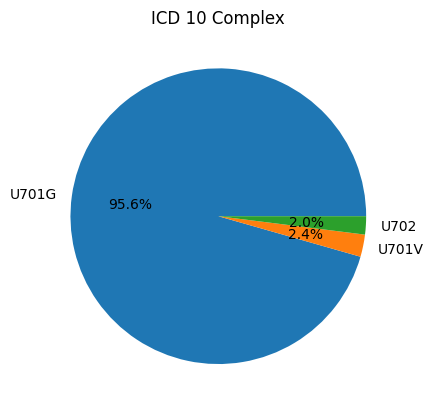

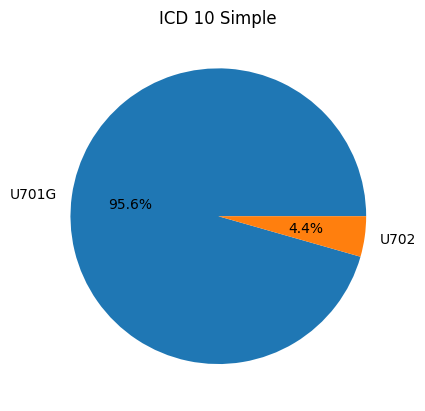

In [106]:
# count of patients for each code
complex_codes = pd_ranked_covid_patients["ICD 10 Complex"].value_counts()
simple_codes = pd_ranked_covid_patients["ICD 10 Simple"].value_counts()
print(complex_codes)
print(simple_codes)
# create a pi chart with the complex codes with percentages and absolute numbers
import matplotlib.pyplot as plt
plt.pie(complex_codes, labels=complex_codes.index, autopct='%1.1f%%')
plt.title('ICD 10 Complex')
plt.show()
plt.pie(simple_codes, labels=simple_codes.index, autopct='%1.1f%%')
plt.title('ICD 10 Simple')
plt.show()

In [107]:
# add ICD 10 Simple for U701V of count 0 to simple_codes
simple_confusion = simple_codes.copy()
simple_confusion["U701V"] = 0
# drop U701G
simple_confusion = simple_confusion.drop("U701G")
simple_confusion

complex_confusion = complex_codes.copy()
# drop U701G
complex_confusion = complex_confusion.drop("U701G")
complex_confusion

,count
ICD 10 Complex,
U701V,22
U702,18


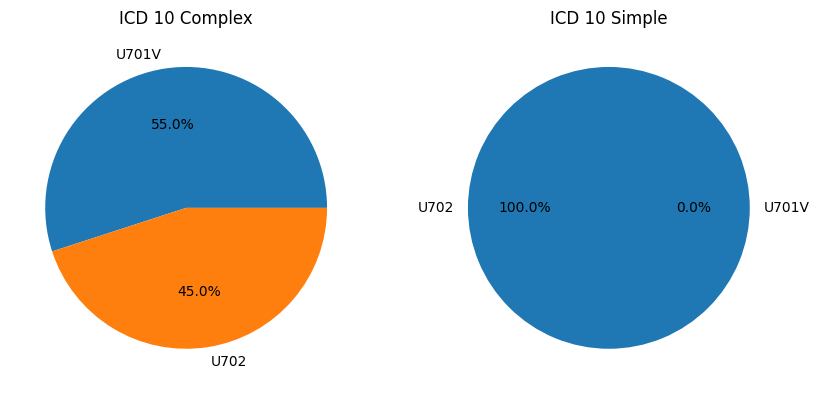

In [114]:
#@title create pie charts
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.pie(complex_confusion, labels=complex_confusion.index, autopct='%1.1f%%')
plt.title('ICD 10 Complex')
plt.subplot(1, 2, 2)
plt.pie(simple_confusion, labels=simple_confusion.index, autopct='%1.1f%%')
plt.title('ICD 10 Simple')
plt.show()

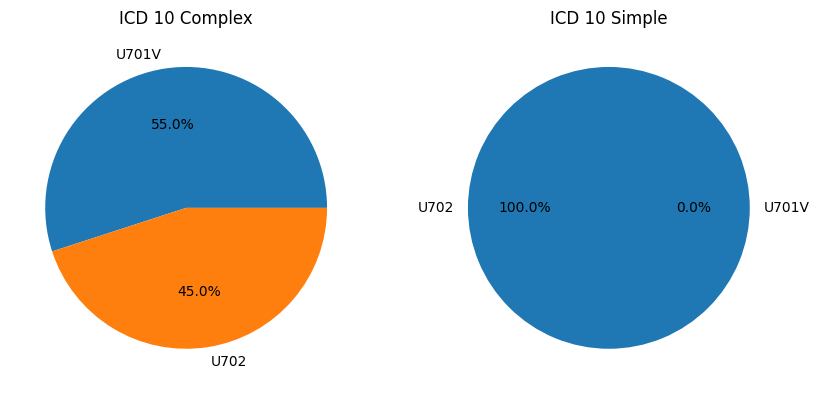

In [115]:
#@title create pie charts

actual = pd_ranked_covid_patients["ICD 10 Complex"]
predicted = pd_ranked_covid_patients["ICD 10 Simple"]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.pie(complex_confusion, labels=complex_confusion.index, autopct='%1.1f%%')
plt.title('ICD 10 Complex')
plt.subplot(1, 2, 2)
plt.pie(simple_confusion, labels=simple_confusion.index, autopct='%1.1f%%')
plt.title('ICD 10 Simple')
plt.show()

In [119]:
# drop U701G from pd_ranked_covid_patients
pd_patients_without_701G = pd_ranked_covid_patients[pd_ranked_covid_patients["ICD 10 Complex"] != "U701G"]
pd_patients_without_701G

,PatientID,DESCRIPTION,Snomed Code,ICD 10 Complex,ICD 10 Simple
17,0455b6ba-6744-3cd1-f00a-5a429d525313,Suspected COVID-19,840544004,U702,U702
76,14bdd429-c67f-11f5-67f3-86165551f25f,Suspected COVID-19,840544004,U701V,U702
90,178318a5-6b9d-5668-d4da-52159a9804b7,Suspected COVID-19,840544004,U702,U702
100,1a0beefd-6119-4967-3a40-c73ae49526bb,Suspected COVID-19,840544004,U702,U702
125,1f45c754-75e4-bcc9-8592-ea76e67d7475,Suspected COVID-19,840544004,U701V,U702
169,27f59b15-3f36-efa7-6b62-f522f07af5e1,Suspected COVID-19,840544004,U701V,U702
191,2d7464f3-5aea-a579-78ff-76abe60319f7,Suspected COVID-19,840544004,U702,U702
212,34e442d3-a2e6-50a4-18fd-62b20446b751,Suspected COVID-19,840544004,U701V,U702
215,3641530a-3e23-c1ee-acef-704e88d378ae,Suspected COVID-19,840544004,U702,U702
249,406c4d79-fab3-342d-7707-417495740931,Suspected COVID-19,840544004,U701V,U702


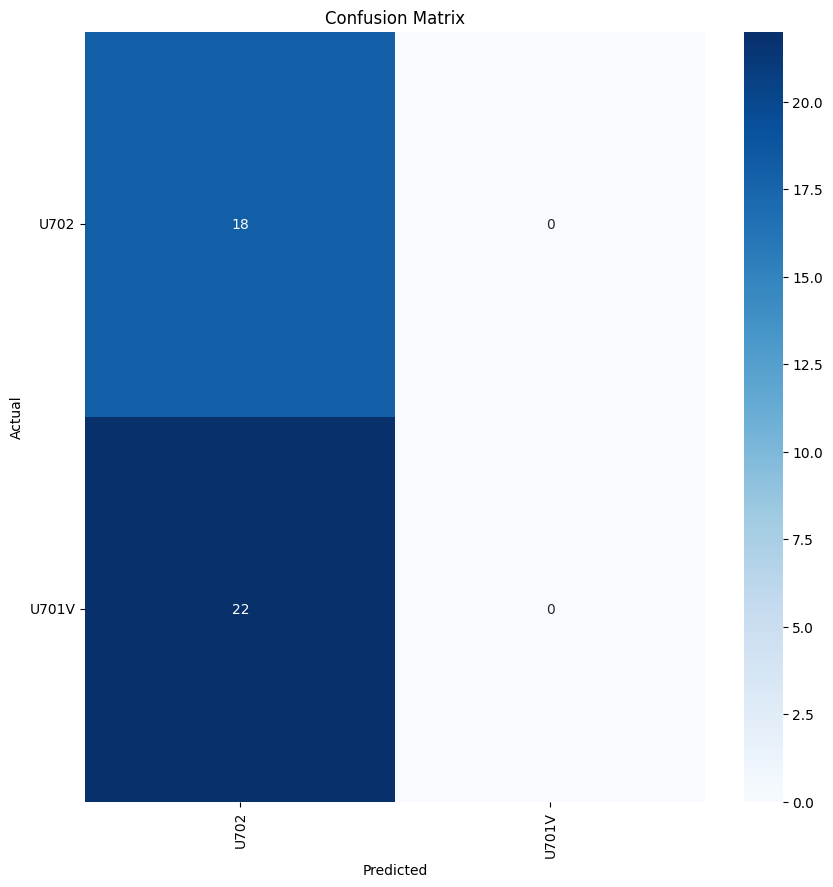

In [146]:
#@title Create confusion matrix with complex as actual and simple as predicted
plt.figure(figsize=(10, 10))
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
cm = confusion_matrix(pd_patients_without_701G["ICD 10 Complex"], pd_patients_without_701G["ICD 10 Simple"], labels=pd_patients_without_701G["ICD 10 Complex"].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# Center the ticks
tick_marks = np.arange(len(pd_patients_without_701G["ICD 10 Complex"].unique()))
plt.xticks(tick_marks + 0.5, ['U702', 'U701V'], rotation=90, ha='center') # center the x ticks
plt.yticks(tick_marks + 0.5, ['U702', 'U701V'], rotation=0, va='center') # center the y ticks

plt.show()

In [151]:
#@title Calculate metrics
pd_patients_without_701G["ICD 10 Complex"].value_counts()
TP = pd_patients_without_701G["ICD 10 Complex"].value_counts()["U702"]
FP = pd_patients_without_701G["ICD 10 Complex"].value_counts()["U701V"]
TN = 0
FN = 0


accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)


# format as table:
# Create a dictionary of metrics
metrics_dict = {
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1 Score": [f1_score],
    "Specificity": [specificity]
}

# Create a Pandas DataFrame
df = pd.DataFrame(metrics_dict)

# Display the DataFrame as a table
display(df)





,Accuracy,Precision,Recall,F1 Score,Specificity
0,0.45,0.45,1.0,0.62069,0.0


In [77]:
# Use the numpy library.
import numpy as np

In [83]:
# Let's set the labels as: positive = 1, and negative = 0
# So if we have 3 labels set to [0,1,0], this indicates, [negative_class, positive_class, negative_class]
# This assumes are are working with a binary classification problem!

# Let's set the labels as: positive = 1, and negative = 0
# So if we have 3 labels set to [0,1,0], this indicates, [negative_class, positive_class, negative_class]
# This assumes are are working with a binary classification problem!

# These are the labels we predicted.
pred_labels = np.asarray([0,1,1,0,1,0,0])
print('pred labels:\t\t', pred_labels)

# These are the true labels.
true_labels = np.asarray([0,0,1,0,0,1,0])
print('true labels:\t\t', true_labels)
true_labels = np.asarray([0,0,1,0,0,1,0])
print('true labels:\t\t', true_labels)

pred labels:		 [0 1 1 0 1 0 0]
true labels:		 [0 0 1 0 0 1 0]
true labels:		 [0 0 1 0 0 1 0]


In [85]:
# True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

# False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

print('TP: %i, FP: %i, TN: %i, FN: %i' % (TP,FP,TN,FN))

TP: 1, FP: 2, TN: 3, FN: 1


In [86]:
from sklearn.metrics import confusion_matrix

In [89]:
print (confusion_matrix(true_labels, pred_labels))
print ('[[TN,FP]')
print ('[[FN,TP]]')

[[3 2]
 [1 1]]
[[TN,FP]
[[FN,TP]]


NameError: name 'pd_ranked_covid_patients' is not defined

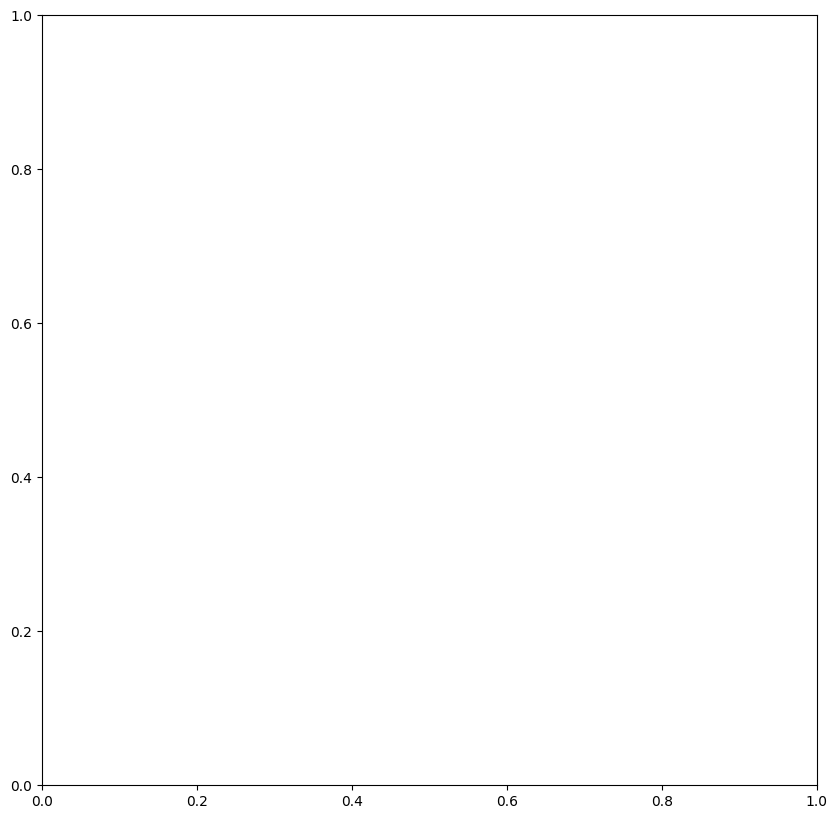

In [1]:
#create a pie plot that shows the diference beetween ICD10 Complex and simple
import matplotlib.pyplot as plt

#create a pie plot that shows the diference beetween ICD10 Complex and simple
import matplotlib.pyplot as plt

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(10, 10))
U701G = '1'
U702G = len(pd_ranked_covid_patients[pd_ranked_covid_patients["ICD 10 Complex"] == "U702G"])
U701V = len(pd_ranked_covid_patients[pd_ranked_covid_patients["ICD 10 Complex"] == "U701V"])
U702V = len(pd_ranked_covid_patients[pd_ranked_covid_patients["ICD 10 Complex"] == "U702V"])
print(U701G, U702G, U701V, U702V)

# Check if all values are zero and handle the case
if sum([U701G, U702G, U701V, U702V]) == 0:
    print("All values are zero. Cannot create a pie chart.")
    # You might want to display a message or an empty plot instead.
else:
    # Create the pie chart
    ax.pie([U701G, U702G, U701V, U702V], labels=["U701G", "U702G", "U701V", "U702V"], autopct='%1.1f%%')
    # Set the title
    ax.set_title('ICD 10 Complex')
    # Display the plot
    plt.show()


# Set the title
ax.set_title('ICD 10 Complex')

# Display the plot
plt.show()


In [41]:
conn.commit()

In [42]:
conn.close()